In [1]:
import numpy as np
import torch, os, cv2
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
N = 40
N_valid = 37
R, C = 580, 890
M = R*C
W = 25

In [23]:
# bring captured image

# 580, 890, N, 3 / N : illumination 개수
b = np.stack([cv2.imread("./color_checker/test_2023_05_08_13_16_160ms_crop/capture_%04d.png"%i) for i in range(N)], axis=2)
b = b[:,:,:,::-1]/255.

In [4]:
# HDR
# b = np.load("./hdr_fat.npy") / 65535.
# b = b[:,:,:,::-1]

In [5]:
b = b[...,:N_valid,:] # 37번 까지만

In [6]:
# bring illumination numpy array
# 580, 890, 40, 25
# A = np.load("./illum_data_0.6.npy")[0]
A = np.load("./illum_data.npy")[0]
A = A[:,:N_valid,:]
print(A.shape)

(516200, 37, 25)


In [7]:
# bring camera response function
# 25, 3
cam_crf = np.load(os.path.join("./dataset/image_formation/CRF_cam.npy"))
map_scale = interp1d([cam_crf.min(), cam_crf.max()], [0.,1.])
cam_crf = map_scale(cam_crf).astype(np.float32)
cam_crf = cam_crf[2:27].T
print(cam_crf.shape)

(3, 25)


In [8]:
# Make M N 3 W

A = np.expand_dims(A, axis=2)
cam_crf = np.expand_dims(np.expand_dims(cam_crf, axis =0), axis=0)
A = A * cam_crf

In [9]:
A.min(), A.max(), A.mean(), b.min(), b.max(), b.mean()

(0.0, 0.783215, 0.01283508, 0.0, 1.0, 0.04135151971717827)

In [10]:
A_tmp = A.reshape(R,C,N_valid,3,W)
A_rgb = A_tmp @ cam_crf.squeeze().T
A_rgb_sum = A_rgb.sum(axis = 4)

In [30]:
# plt.imshow(A_rgb_sum[:,:,37,:])

In [29]:
# plt.imshow(b[:,:,37])

### Optimize with L1 loss

In [11]:
# Reshape to make M, ...
A = A.reshape(R*C, 1, 3*N_valid, W)
b = b.reshape(R*C, 1, 3*N_valid, 1)    
    
batch_size = 100000
num_iter = 5000
num_batches = int(np.ceil(M / batch_size))
loss_f = torch.nn.L1Loss()
losses = []
X_np_all = torch.zeros(M, 1, W, 1)

# define initial learning rate and decay step
lr = 0.5
decay_step = 800

# training loop over batches
for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, M)
    batch_size_ = end_idx - start_idx
    A_batch = torch.from_numpy(A[start_idx:end_idx]).to(device)
    B_batch = torch.from_numpy(b[start_idx:end_idx]).to(device)
    X_est = torch.randn(batch_size_, 1, W, 1, requires_grad=True, device=device)
    optimizer = torch.optim.Adam([X_est], lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_step, gamma=0.5)

    optimizer.zero_grad()
    for i in range(num_iter):
        loss = loss_f(A_batch @ X_est, B_batch)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        if i % 100 == 0:
            print(f"Batch {batch_idx + 1}/{num_batches}, Iteration {i}/{num_iter}, Loss: {loss.item()}, LR: {optimizer.param_groups[0]['lr']}")

    X_np_all[start_idx:end_idx] = X_est.detach().cpu()

X_np_all = X_np_all.numpy()

Batch 1/6, Iteration 0/5000, Loss: 0.10507074230610726, LR: 0.5
Batch 1/6, Iteration 100/5000, Loss: 0.018153124648032155, LR: 0.5
Batch 1/6, Iteration 200/5000, Loss: 0.017949079867342982, LR: 0.5
Batch 1/6, Iteration 300/5000, Loss: 0.017847164407005362, LR: 0.5
Batch 1/6, Iteration 400/5000, Loss: 0.017780708815574045, LR: 0.5
Batch 1/6, Iteration 500/5000, Loss: 0.01776784814771921, LR: 0.5
Batch 1/6, Iteration 600/5000, Loss: 0.017755739050433234, LR: 0.5
Batch 1/6, Iteration 700/5000, Loss: 0.01771523534415438, LR: 0.5
Batch 1/6, Iteration 800/5000, Loss: 0.01770150880777593, LR: 0.25
Batch 1/6, Iteration 900/5000, Loss: 0.011844591151705225, LR: 0.25
Batch 1/6, Iteration 1000/5000, Loss: 0.011883607125022117, LR: 0.25
Batch 1/6, Iteration 1100/5000, Loss: 0.011915359493193257, LR: 0.25
Batch 1/6, Iteration 1200/5000, Loss: 0.011924335086755701, LR: 0.25
Batch 1/6, Iteration 1300/5000, Loss: 0.01195959303862706, LR: 0.25
Batch 1/6, Iteration 1400/5000, Loss: 0.01195508268185276, 

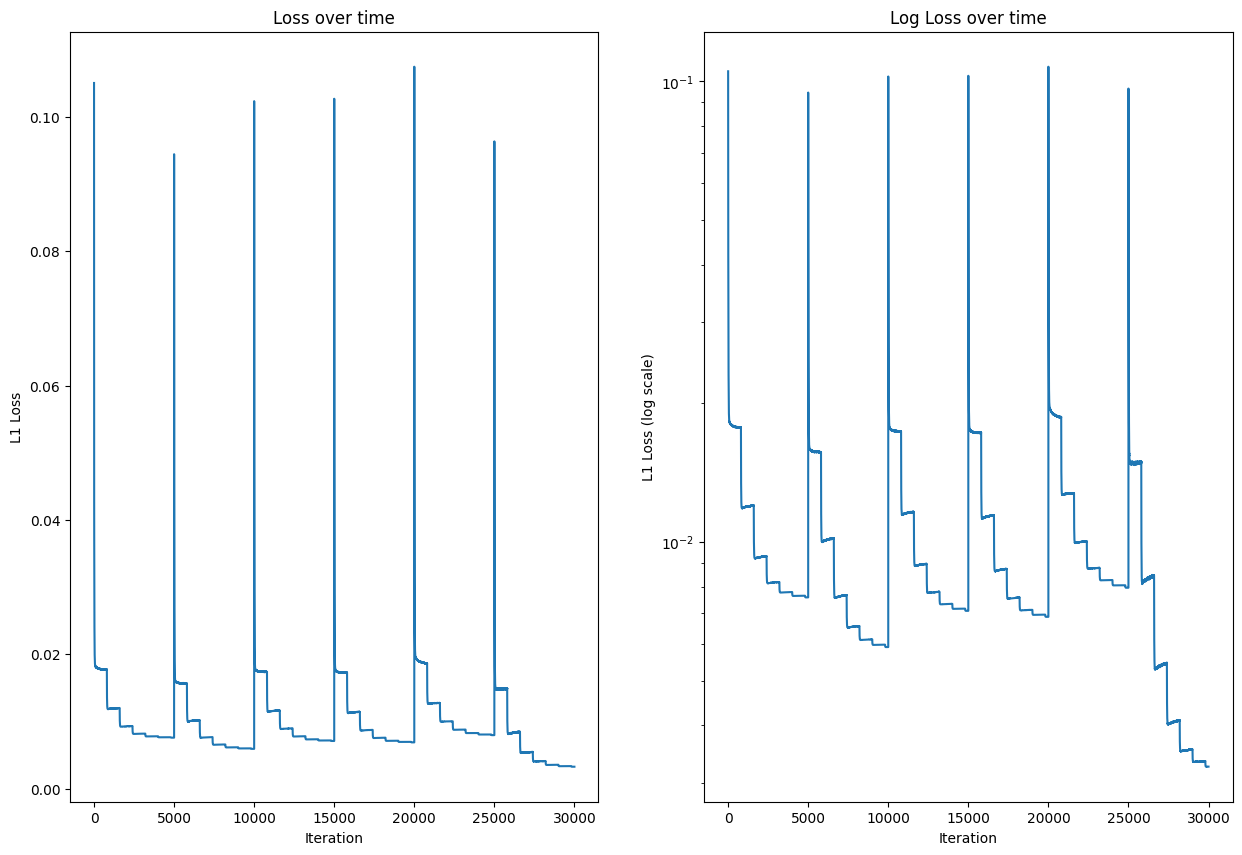

In [12]:
# plot losses over time
plt.figure(figsize=(15,10))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Loss over time")
plt.xlabel("Iteration")
plt.ylabel("L1 Loss")

plt.subplot(1, 2, 2)
plt.semilogy(losses)
plt.title("Log Loss over time")
plt.xlabel("Iteration")
plt.ylabel("L1 Loss (log scale)")

plt.show()

In [13]:
X_np_all.shape

(516200, 1, 25, 1)

In [14]:
X_np_all = X_np_all.reshape(R, C, 25)

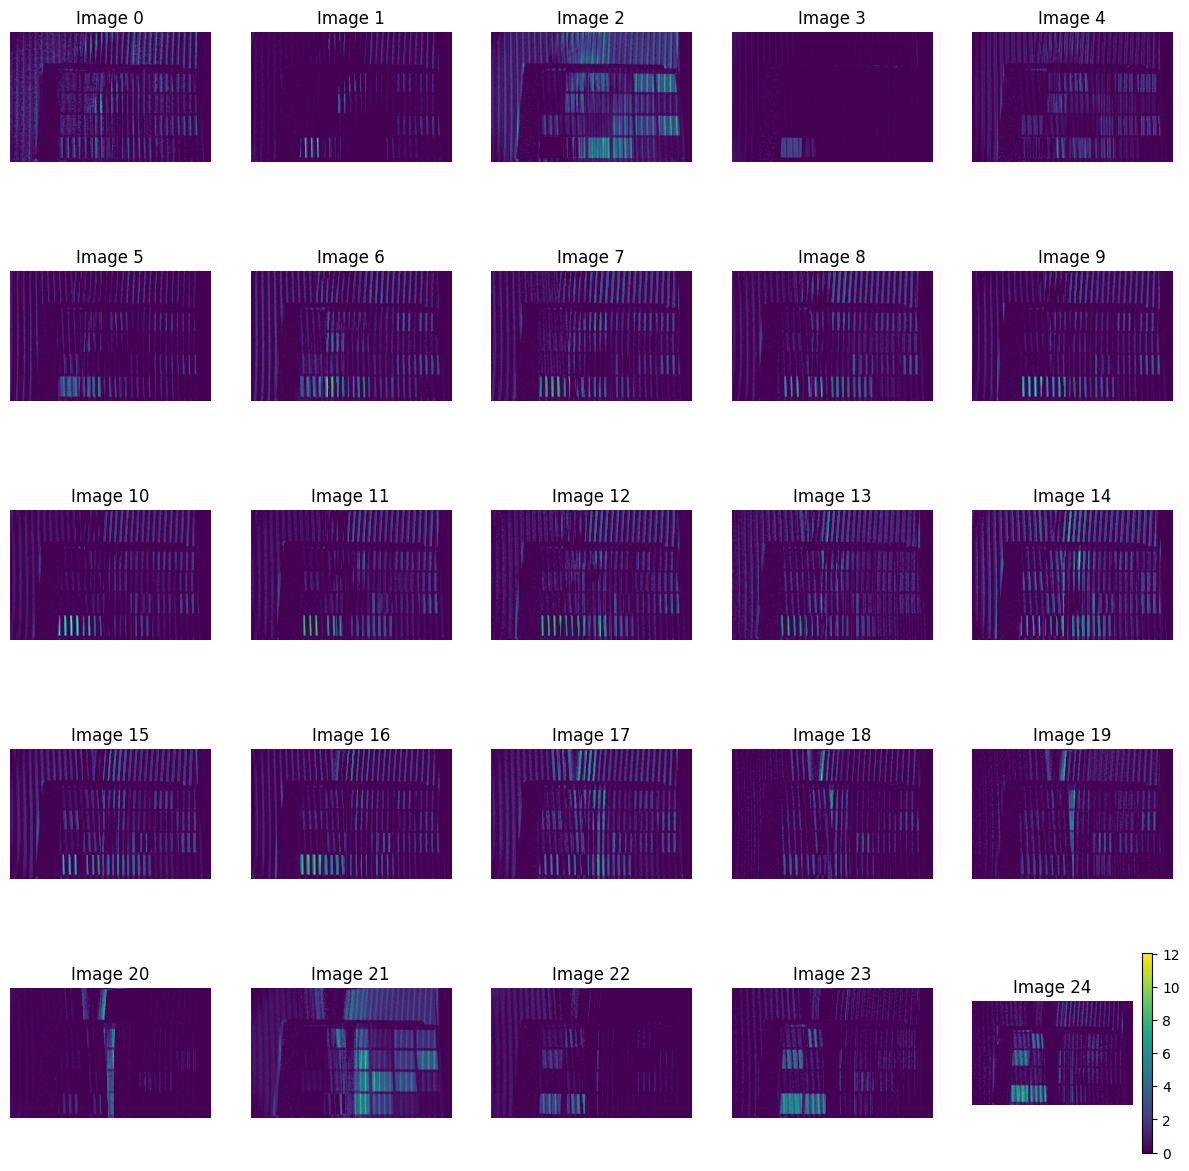

In [15]:
max_images_per_column = 5
num_columns = (W + max_images_per_column - 1) // max_images_per_column
plt.figure(figsize=(15, 3*num_columns))

for c in range(num_columns):
    start_index = c * max_images_per_column
    end_index = min(start_index + max_images_per_column, W)
    num_images = end_index - start_index
    
    for i in range(num_images):
        plt.subplot(num_columns, num_images, i + c * num_images + 1)
        plt.imshow(X_np_all[:, :, i + start_index], vmin=0)
        plt.axis('off')
        plt.title(f"Image {i + start_index}")
        
        if i + start_index == W - 1:
            plt.colorbar()

In [17]:
CRF = cam_crf.reshape(3,25).T

In [19]:
rgb_img = X_np_all@cam_crf.squeeze().T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


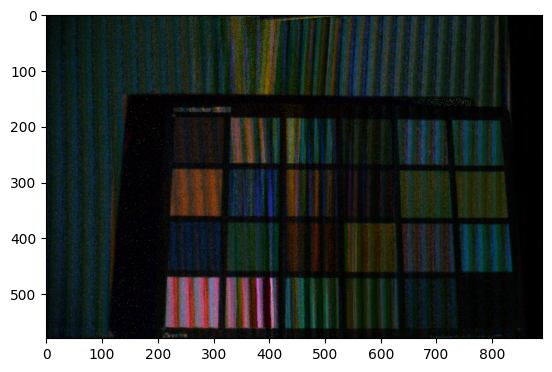

In [20]:
plt.imshow(rgb_img/ rgb_img.max())